# 自然语言和单词的分布式表示
- 编程语言是一种“硬语言”，自然语言是一种“软语言”
- 单词的含义：语言是由文字构成的，单词是文字的一部分，单词的含义是文字的意义。所以让计算机去理解单词的含义才是重点，让计算机理解单词的含义分为以下三种方法：
  - 基于同义词的字典方法
  - 基于计数的方法
  - 基于推理的方法
## 基于同义词的字典方法
像做新华字典那样：人为的设计同义词、上位-下位、整体-部分。知名的同义词字典方法：WordNet。使用同义词字典存在的问题：
- 难以顺应时代的变化
- 主要靠人，后期人力维护成本高

## 基于计数的方法
- 语料库
- 将单词要转变成向量

In [1]:
# 语料库预处理小案例
text = 'you say goodbey and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
print(text)
words = text.split(' ')
words

you say goodbey and i say hello .


['you', 'say', 'goodbey', 'and', 'i', 'say', 'hello', '.']

In [2]:
# 将词和字典互转
word_to_id = {}
id_to_word = {}
for word in words:
    # 排除掉重复元素
    if word not in word_to_id:
        idx = len(word_to_id)
        word_to_id[word] = idx
        id_to_word[idx] = word
print(f'word_to_id:{word_to_id}')
print(f'id_to_word:{id_to_word}')

word_to_id:{'you': 0, 'say': 1, 'goodbey': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
id_to_word:{0: 'you', 1: 'say', 2: 'goodbey', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
# 再将词转换为id，这里id可以重复
text_id = [word_to_id[word] for word in words]
print(f'text_id:{text_id}')

text_id:[0, 1, 2, 3, 4, 1, 5, 6]


In [4]:
# 将上面的过程定义成一个函数
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {} 
    for word in words:
        if word not in word_to_id:
            idx = len(word_to_id)
            word_to_id[word] = idx
            id_to_word[idx] = word
    corpus = np.array([word_to_id[word] for word in words])
    return corpus, word_to_id, id_to_word
text = 'you say goodbey and I say hello.'
preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbey': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbey', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

### 分布式假设
- 单词本身并么有意义，单词的含义是由它的上下文决定的
### 共现矩阵
- 用单词的上下文来描述单词
- 共现矩阵是一个方阵，它的大小是语料库中单词的个数
- 共现矩阵是沿着对角线对称的矩阵，因为它的第i行和第i列都是表达第i个单词的上下文
- 共现矩阵只能简单的描述那些单词是我的上下文，而不能描述清楚这些上下文和自己的关联究竟有多强，这就是后面要使用PPMI的原因

In [5]:
# 共现矩阵示例
text = 'you say goodbey and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            # 左边界，第一个单词的左边界需要考虑
            # word_id的长度已经是单词的个数了，所以重复的单词不会被考虑了
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix
print(corpus)
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)
print(co_matrix)

[0 1 2 3 4 1 5 6]
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 余弦相似度
- 判定两个单词（向量）的相似成都
- 用公式表示为：
  $$
  cos(A, B) = \frac{A \cdot B}{||A|| \cdot ||B||}
  $$   

In [6]:
# 余弦相似度代码实现
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

text = 'you say goodbey and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)
print(f'co_matrix:\n{co_matrix}')

you_v = co_matrix[word_to_id['you']]
i_v = co_matrix[word_to_id['i']]
print(f'you_v:\n{you_v}')
print(f'i_v:\n{i_v}')
print(f'cos_similarity(you_v, i_v):{cos_similarity(you_v, i_v)}')

co_matrix:
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
you_v:
[0 1 0 0 0 0 0]
i_v:
[0 1 0 1 0 0 0]
cos_similarity(you_v, i_v):0.7071067691154799


## 基于计数的方法改进
### 点互信息
- 英文缩PMI：为了解决高频词汇相似度比较高的问题
- 英文缩写PPMI：为了解决无穷小的问题，引入点交互信息的概念
- 共现矩阵只是简单的一些0，1。需要使用余弦相似度才能计算出来两个单词的相似度
- 将共现矩阵转化为正点互信息矩阵，可以更加好的描绘出单词上下文对他的贡献
- 但是当一个语料库变大时，去计算共现矩阵或者点互信息矩阵的时间复杂度会变得很高

In [7]:
# 正点互信息矩阵
import numpy as np
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    # 共现矩阵中所有不为0的元素的个数
    N = np.sum(C)
    # 共现矩阵中每一行上下文的个数
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % 101 == 0:
                    print(f'{cnt}/{total}')
    return M

text = 'you say goodbey and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)
print(f'co_matrix:\n{co_matrix}')
W = ppmi(co_matrix)
print(f'W:\n{W}')

co_matrix:
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
W:
[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


### 降维
- 这里主要使用SVD（奇异值分解）的方式降维
- 在这个案例中，如果使用共现矩阵或者正点相互矩阵，需要一个7x7的矩阵
- 经过SVD降维之后，我们可以自动选取维度为2的矩阵，这样就可以得到两个单词的相似度
- 将其可视化展示出来，看一看见i和you的距离比较近，hello和goodbey的距离比较近，这也是和我们正常的认知是一样的

In [8]:
# 使用奇异值矩阵分解的案例
import sys
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

text = 'you say goodbey and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)
print(f'co_matrix:\n{co_matrix}')
W = ppmi(co_matrix)
print(f'W:\n{W}')
U, S, V = LA.svd(W)
print(f'U.shpae: {U.shape}')
print(f'S.shape: {S.shape}')
print(f'V.shape: {V.shape}')
print(f'U:\n{U}')
print(f'S:\n{S}')
print(f'V:\n{V}')

co_matrix:
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
W:
[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]
U.shpae: (7, 7)
S.shape: (7,)
V.shape: (7, 7)
U:
[[ 0.00000000e+00  3.40948761e-01 -3.88578059e-16 -1.20516241e-01
  -9.32324946e-01 -1.11022302e-16  8.76837125e-17]
 [-5.97636402e-01  0.00000000e+00  1.80237904e-01  0.00000000e+00
   0.00000000e+00 -7.81245828e-01  0.00000000e+00]
 [-5.55111512e-17  4.36312199e-01 -2.22044605e-16 -5.08782864e-01
   2.

In [9]:
# 现在将样本降为二维
print(F'U[:, :2]:\n{U[:, :2]}')

U[:, :2]:
[[ 0.0000000e+00  3.4094876e-01]
 [-5.9763640e-01  0.0000000e+00]
 [-5.5511151e-17  4.3631220e-01]
 [-4.9782813e-01  2.2204460e-16]
 [-3.1237506e-17  4.3631220e-01]
 [-3.1237506e-17  7.0923710e-01]
 [-6.2848860e-01 -2.4980018e-16]]


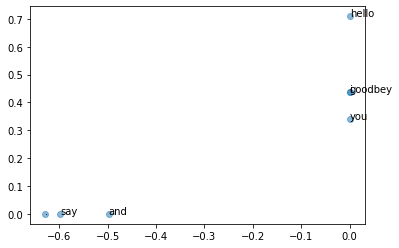

In [10]:
# 画出降维后的单词向量空间
for word, word_id in word_to_id.items():
    plt.annotate(word, xy=(U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### PTB语料库
- 网络问题，ptb数据集搞不下来

In [ ]:
%run ./dataset/ptb.py